<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Geojson-incorporation" data-toc-modified-id="Geojson-incorporation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Geojson incorporation</a></span></li></ul></div>

# Geojson incorporation

Now, let's trying to plot a geojson file and function to join data with map

In [3]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive/")
    %cd "/content/gdrive/My Drive/Colab Notebooks/bikes-theft-model"

import numpy as np
import pandas as pd

import branca, geopandas
import folium # package for making maps, please make sure to use a version older than 1.0.0.
from folium.plugins import TimeSliderChoropleth

import ipywidgets
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'ipywidgets'

In order to be able to plot the geographical maps of Toronto and Ottawa, the function of `plotMap` was defined, which plots the map of the filtered city and a specific time. To facilitate the process, functions were defined to make the reading of the data and the maps (`read_data_map`), as well as a function to correlate the geopositional information with their respective information (`mapJoinTable`). 

In [2]:
''' Important functions '''
# Read data & geomap with respect to city
def read_data_map(data_path, geo_path, city):
    skip_cols = ['City']
    
    # Read data of Toronto an Ottawa cities
    canada_data = pd.read_csv(data_path, index_col = 0)
    canada_data = canada_data[canada_data["City"] == city].drop(columns = skip_cols)
    
    if "%Theft/sqKm" in canada_data.columns:
        canada_data["%Theft/sqKm"] = canada_data["%Theft/sqKm"].replace({np.inf:0}) * 100
    if "%PopulationBike" in canada_data.columns:
        canada_data["%PopulationBike"] = canada_data["%PopulationBike"].replace({np.inf:0}) * 100
    
    # Read maps information
    canada_map = geopandas.read_file(geo_path, driver = "GeoJSON").rename(columns = {"id":"GeoUID"})
    return canada_data, canada_map

# Join geopandas with data with two possibles cases (with column or with points in polygon)
def mapJoinTable(df_point, df_map):
    if "GeoUID" in df_point:
        df_point["GeoUID"] = df_point["GeoUID"].astype(str); df_map["GeoUID"] = df_map["GeoUID"].astype(str)
        df_map["id"] = df_map["GeoUID"] # Save column
        return df_map.join(df_point.set_index("GeoUID"), how = "left", on = "GeoUID")
    try:
        df_point = geopandas.GeoDataFrame(df_point, geometry = geopandas.points_from_xy(df_point.x, df_point.y)).set_crs("EPSG:4326")
    except:
        df_point = geopandas.GeoDataFrame(df_point, geometry = geopandas.points_from_xy(df_point.Long, df_point.Lat)).set_crs("EPSG:4326")
    df_result = geopandas.tools.sjoin(df_point, df_map, how='right') # Keep multipoligon data
    return df_result

# Plot a single map
def plotMap(df_data, df_geomap, value_var = "Cost_of_Bike", caption = "Cost of bike by region", 
            name = 'Canada maps', fields2show = ['Cost_of_Bike'], aliases = ['cost']):
    # Map creation colors
    min_cn, max_cn = df_data[value_var].quantile([0.01,0.99]).apply(round, 2)
    colormap = branca.colormap.LinearColormap(
        colors=['white','yellow','orange','red','darkred'], vmin=min_cn, vmax=max_cn,
        index = df_data[value_var].quantile([0.2,0.4,0.6,0.8])
    )
    colormap.caption = caption
    
    # Join both maps only in one
    df_data_geomap = mapJoinTable(df_data, df_geomap).fillna(0)
    
    # Geo map skeleton
    init_local = [z[0] for z in df_data_geomap.iloc[0]["geometry"].centroid.xy][::-1]
    geomap = folium.Map(location = init_local, zoom_start=10, tiles="OpenStreetMap")

    style_function = lambda x: {
        'fillColor': colormap(x['properties'][value_var]),
        'color': 'black', 'weight':2, 'fillOpacity':0.5
    }

    stategeo = folium.GeoJson(df_data_geomap.to_json(), name=name, style_function = style_function,
        tooltip = folium.GeoJsonTooltip(fields = fields2show, aliases = aliases, localize=True)
    ).add_to(geomap)

    colormap.add_to(geomap)
    return geomap

# Plot differents maps with slider
def foliumSlider(df_data, df_geomap, value_var, index_var, caption = "Cost of bike by region", 
                 name = 'Canada maps', fields2show = ['Cost_of_Bike'], aliases = ['cost']):
    
    # Map creation colors
    min_cn, max_cn = df_data[value_var].quantile([0.01,0.99]).apply(round, 2)
    colormap = branca.colormap.LinearColormap(
        colors=['white','yellow','orange','red','darkred'], vmin=min_cn, vmax=max_cn
    )
    colormap.caption = caption
    
    # Join both maps only in one
    df_data_geomap = mapJoinTable(df_data, df_geomap).fillna(0).sort_values(index_var)
    
    # Get styledata for folium
    styledata = {}
    index_lab = np.sort(df_data[index_var].unique()) # Total of maps to graph
#     temp = list(pd.date_range( "2017-1", "2017-12", freq = "MS").strftime("%Y-%m"))
    
    for beat, value in enumerate(df_geomap.index):
        res_beat = df_data[df_data["GeoUID"] == df_geomap.loc[value,"GeoUID"]]
        # fill missing value by zero
        c_count = res_beat.set_index(index_var)[value_var].reindex(index_lab).fillna(0) 
#         c_count = res_beat.set_index(index_var)[value_var].fillna(0) 
        df_tmp = pd.DataFrame(
            {'color': [colormap(count) for count in c_count], 'opacity':0.5},
            index = index_lab
        )
        styledata[str(beat)] = df_tmp
    
    styledict = {str(beat): data.to_dict(orient='index') for beat, data in styledata.items()}
    
    # Geo map skeleton
    init_local = [z[0] for z in df_geomap.iloc[0]["geometry"].centroid.xy][::-1]
    geomap = folium.Map(location = init_local, zoom_start=10, tiles="OpenStreetMap")
    
    # Plot map and time slider
    g = TimeSliderChoropleth(df_data_geomap.to_json(), styledict = styledict).add_to(geomap)
    folium.GeoJson(df_data_geomap.to_json(), style_function = lambda x: {'color': 'black', 'weight':2, 'fillOpacity':0}, 
        tooltip=folium.GeoJsonTooltip(fields=fields2show, aliases=aliases, localize=True)).add_to(geomap)

    colormap.add_to(geomap)
    return geomap

# Plot animation of every year
def updatePlot(data, col_instant, instant, fun_plot, *args, **kwargs):
    df = data[data[col_instant] == instant] # Data filtered
    fun_plot(df, *args, **kwargs) # Update plot

To understand better the use of the functions, let's see a simple example of how to use them. Let's take the city of Toronto as an example. To do this, let's take the city of Toronto as an example and filter it by the hour with the highest records of theft. Finally, let's join the two tables and see what happens.

In [3]:
# Read geojson/data and put in pandas dataframe
toronto_data, toronto_map = read_data_map(data_path = "./Data/Stolen_bikes_johan_2016.csv", 
                                        geo_path = "./Data/Maps/toro_population_toronto.geojson", 
                                        city = "Toronto")

max_hour = toronto_data.groupby("Hour").size().idxmax()
toronto_data_demo = toronto_data[toronto_data["Hour"] == max_hour].copy() # Important data = Demo
toronto_data_geomap = mapJoinTable(toronto_data_demo, toronto_map)

display(toronto_data_geomap.head().append(toronto_data_geomap.tail()), toronto_data_geomap.shape, toronto_data_geomap.columns)
# display(toronto_map.head().append(toronto_map.tail()), toronto_map.shape, toronto_map.columns)

,a,t,dw,hh,GeoUID,pop,pop2,rgid,rpid,ruid,...,Hour,PopulationCT,BicycleT,Area(sqKm),SumThBikes,BikesThDensity,BikesDensity,PopulationDensity,%Theft/sqKm,%PopulationBike
0,0.73445,CT,1246,1143,5350160.00,3116,3230,35,35535,3520005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.97486,CT,2130,2051,5350351.01,5497,5284,35,35535,3520005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.11566,CT,2688,2535,5350102.02,4313,4301,35,35535,3520005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.20716,CT,728,684,5350028.01,1387,988,35,35535,3520005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.62823,CT,2629,2515,5350164.00,6258,6331,35,35535,3520005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567,1.12407,CT,2117,1953,5350270.01,4980,5152,35,35535,3520005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
568,1.10548,CT,2376,2250,5350196.02,5635,5748,35,35535,3520005,...,12.0,5635.0,75.0,1.10548,1.0,0.904584,67.843833,5097.333285,1.333333,1.330967
569,0.11899,CT,359,340,5350102.05,861,812,35,35535,3520005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,0.29723,CT,5192,4954,5350008.01,7503,2729,35,35535,3520005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,0.19221,CT,3761,3519,5350063.06,5171,4737,35,35535,3520005,...,12.0,5171.0,130.0,0.19221,4.0,20.810572,676.343583,26902.866656,3.076923,2.514020


(572, 23)

Index(['a', 't', 'dw', 'hh', 'GeoUID', 'pop', 'pop2', 'rgid', 'rpid', 'ruid',
       'rguid', 'geometry', 'id', 'Hour', 'PopulationCT', 'BicycleT',
       'Area(sqKm)', 'SumThBikes', 'BikesThDensity', 'BikesDensity',
       'PopulationDensity', '%Theft/sqKm', '%PopulationBike'],
      dtype='object')

We observe the lack of information with the `NaN` values. This information, for these specific hours was not available. For other values, let's plot the heatmap by region, using as an analysis variable the density of the percentage of thefts per hour.

In [4]:
fields = toronto_data_demo.columns.drop(['GeoUID', 'Hour']).to_list()
print("[INFO]: Hour =", max_hour)
plotMap(toronto_data_demo, toronto_map, value_var = "%Theft/sqKm", caption = "%Theft/sqKm of bike by region", 
            name = 'Canada maps', fields2show = fields, aliases = fields)

[INFO]: Hour = 12.0


With the little information available for this specific hour, we can see that the percentage density of thefts (to a greater extent) occurred outside. Additionally, the states with the highest density of robberies are some of the largest, due to the high population that is usually concentrated in regions with high volume density. 

Let's define now a more general procedure to visualize any region, indicating a specific year and the target city.

In [5]:
# User parameters
year = "2016"
hour = 12
city = "Toronto"

# Process
if city == "Ottawa": geo_path = "./Data/Maps/ontario_populatio_ottawa.geojson"
else: geo_path = "./Data/Maps/toro_population_toronto.geojson"
data_path = "./Data/Stolen_bikes_johan_{}.csv".format(year)
canada_data, canada_map = read_data_map(data_path = data_path, geo_path = geo_path, city = city)
canada_data = canada_data[canada_data["Hour"] == hour].copy()
fields = canada_data.columns.drop(['GeoUID', 'Hour']).to_list()
plotMap(canada_data, canada_map, value_var = "%Theft/sqKm", caption = "%Theft/sqKm of bike by region", 
            name = 'Canada maps', fields2show = fields, aliases = fields)

Finally, to make a more reliable analysis, let's look at the behavior of the two cities through the different times of day of all the years available.

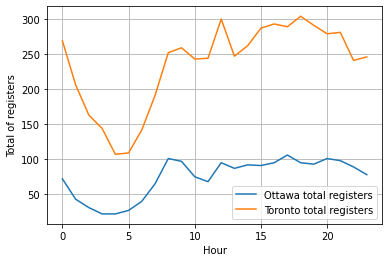

In [6]:
if city == "Ottawa": geo_path = "./Data/Maps/ontario_populatio_ottawa.geojson"
else: geo_path = "./Data/Maps/toro_population_toronto.geojson"
data_path = "./Data/Stolen_bikes_johan_{}.csv".format(year)


# Read data of Toronto an Ottawa cities
path_dict = {"Ottawa": {"data": "./Data/Stolen_bikes_johan_{}.csv", 
                        "geo": "./Data/Maps/ontario_populatio_ottawa.geojson"},
             "Toronto":{"data": "./Data/Stolen_bikes_johan_{}.csv", 
                        "geo": "./Data/Maps/toro_population_toronto.geojson"}
            }

slider_dict_result = {}

for iax, city in enumerate(["Ottawa", "Toronto"]):
    for i, year in enumerate(["2014", "2015", "2016", "2017", "2018", "2019"]):
        data, canada_map = read_data_map(path_dict[city]["data"].format(year), path_dict[city]["geo"], city)
#         data["year"] = year
        if i == 0: canada_data = data.copy()
        else: canada_data = canada_data.append(data) # Join all data in just one table
    
    canada_data = canada_data.groupby(["GeoUID", "Hour"]).agg("mean").reset_index()
#     display(canada_data.head().append(canada_data.tail()), canada_data.shape, canada_data.columns)
    
    slider_dict_result[city] = {}; hours_reg = []
    for h in canada_data["Hour"].sort_values().unique(): # Save each graph by hour
        data = canada_data[canada_data["Hour"] == h].copy()
        fields = data.columns.drop(['GeoUID', 'Hour']).to_list()
        plotmap = plotMap(data, canada_map, value_var = "%Theft/sqKm", caption = "%Theft/sqKm of bike by region", 
            name = 'Canada maps', fields2show = fields, aliases = fields)
        slider_dict_result[city][str(int(h))] = plotmap
        hours_reg.append(len(data))
    
    plt.plot(hours_reg, label = "{} total registers".format(city))

plt.xlabel("Hour"); plt.ylabel("Total of registers")
plt.legend(); plt.grid(); plt.show()

In [7]:
### User parameters
hour = 17
city = "Ottawa"
slider_dict_result[city][str(hour)]    

In [8]:
### User parameters
hour = 17
city = "Toronto"
slider_dict_result[city][str(hour)]    

By the 17th hour, through the years, we see that the city of Ottawa has a higher density of robberies tending again to the outskirts of the city. With this information, we could start the corresponding investigations to find out the cause of this. Possibly it is easier for bicycle thieves to steal at these extremes, or it may be due to a socio-economic factor.

On the other hand, the density of robberies per area is a little more uniform in the city of Toronto, compared to the city of Ottawa. Despite the lack of information in this city, we can observe certain patterns of behavior over the years as groups of regions with high rates of theft in the center and north-center of the city.

By comparing the two cities we can ensure that there is more confidence in the data for the city of Toronto (as we have more information for this city). Additionally, a factor to consider is the maximum density value between the two cities. For the city of Ottawa, we have a percentage of 10% stolen cycles per km$^2$, in contrast to the city of Toronto with a percentage of 20% (double), which indicates that of each cycle stolen in Ottawa per area, two cycles are stolen in Toronto. 

In [9]:
# # Read data of Toronto an Ottawa cities
# path_dict = {"Ottawa": {"data": "./Data/Stolen_bikes_johan_2016.csv", 
#                         "geo": "./Data/Maps/ontario_populatio_ottawa.geojson"},
#              "Toronto":{"data": "./Data/Stolen_bikes_johan_2016.csv", 
#                         "geo": "./Data/Maps/toro_population_toronto.geojson"}
#             }

# slider_dict_result = {}
# fields = ['a', 't', 'dw', 'hh']
# for city in ["Ottawa", "Toronto"]:
#     canada_data, canada_map = read_data_map(path_dict[city]["data"], path_dict[city]["geo"], city)
# #     fields = canada_data.columns.drop(['GeoUID', 'Hour']).to_list()
#     slider_dict_result[city] = foliumSlider(canada_data, canada_map, "%Theft/sqKm", 
#             "Hour", caption = "CountTheft of bike by region", 
#             name = city + " maps", fields2show = fields, aliases = fields)

In [10]:
# slider_dict_result["Ottawa"]

In [11]:
# slider_dict_result["Toronto"]

In [12]:
# Other way
# ipywidgets.widgets.interact(updatePlot, data = canada_data, col_instant = "Occurrence_Month", 
#                             instant = canada_data["Occurrence_Month"].unique(),
#                             fun_plot = x, df_geomap = canada_map, value_var = "CountTheft",
#                             caption = "CountTheft of bike by region", name = 'Canada maps', 
#                             fields2show = ['CountTheft'], aliases = ['theft'])